In [19]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import zipfile
from collections import Counter
import random
import utils
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd 
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



[nltk_data] Downloading package punkt to /home/manak18340/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


In [3]:
# !pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu111/torch_nightly.html -U


In [4]:
# conda install -c conda-forge spacy


### Generating Dependency Embeddings

In [3]:
filepath = open("../dependency graphs/webnlg_dependencygraph.pickle", "rb")

webnlg_dependencygraph = pickle.load(filepath)
filepath.close()

In [23]:
sample_idx = 4540

webnlg_dependencygraph[list(webnlg_dependencygraph.keys())[sample_idx]]

{'split_sentences': ['Born in Faversham, Adam Holloway served in the Grenadier Guards and began his career on 5th May 2005.',
  'his alma mater was Magdalene College in Cambridge.'],
 'tuples': ['Adam_Holloway | birthPlace | Faversham ',
  ' Adam_Holloway | activeYearsStartDate | 2005-05-05 ',
  ' Adam_Holloway | militaryBranch | Grenadier_Guards ',
  ' Adam_Holloway | almaMater | Magdalene_College,_Cambridge'],
 'dependency_relations': [[Born in Faversham, Adam Holloway served in the Grenadier Guards and began his career on 5th May 2005.,
   {'text': 'Born', 'Relation': 'advcl', 'Head': 'served', 'Children': ['in']},
   {'text': 'in',
    'Relation': 'prep',
    'Head': 'Born',
    'Children': ['Faversham']},
   {'text': 'Faversham', 'Relation': 'pobj', 'Head': 'in', 'Children': []},
   {'text': ',', 'Relation': 'punct', 'Head': 'served', 'Children': []},
   {'text': 'Adam',
    'Relation': 'compound',
    'Head': 'Holloway',
    'Children': []},
   {'text': 'Holloway',
    'Relation'

In [24]:

def read_data(master_dict):
    words = []
    for key in list(master_dict.keys()):
        split_sentences = master_dict[key]['split_sentences']
        for sentence in split_sentences:
            words.extend(sentence.split())
    return words


In [25]:
words = read_data(webnlg_dependencygraph)

In [26]:
len(words)

557148

In [27]:

def build_vocab(words, vocab_size):
    """builds vocabulary of vocab_size from the words."""
    vocab = dict()
    count = [('UNK', -1)]
    count.extend(Counter(words).most_common(vocab_size - 1))
    index = 0
    utils.make_dir('processed')
    with open('processed/vocab_1000.tsv', "w") as f:
        for word, _ in count:
            vocab[word] = index
            index += 1
    return vocab



In [28]:
vocab = build_vocab(words, 20000)


In [29]:
def convert_words_to_vocab(words, vocab):
    """Replace all the words in dataset with the index in the vocab"""
    return [vocab[word] if word in vocab else 0 for word in words]



In [30]:
words2vocab = convert_words_to_vocab(words,vocab)

In [31]:
w2i = {w: i for i, w in enumerate(sorted(vocab))}
i2w = {i: w for i, w in enumerate(sorted(vocab))}

In [ ]:
def generate_context_dataset(webnlg_dependencygraph, context_size):
    data = []
    sentence2context_target = {}

    for document in webnlg_dependencygraph:
        sentence2dep = webnlg_dependencygraph[document]
        split_sentences = sentence2dep['split_sentences']
        tuples = sentence2dep['tuples']
        dependency_relations = sentence2dep['dependency_relations']

        for rel in dependency_relations:
            sentence = rel[0]
            for token in np.array(rel)[1:]:
                children = np.array(token['Children'])
                target = token['text']
                if len(children) >= 2*context_size:
                    context = children[:4].tolist()
                    sentence2context_target[sentence] = (context, target)
                    data.append((context, target))
                    
                    

        
    
    return data , sentence2context_target
        


In [16]:
data, sentence2context_target = generate_context_dataset(webnlg_dependencygraph, 2)
print(data[:5])
print(len(data))

/tmp/ipykernel_640022/4198928870.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for token in np.array(rel)[1:]:


[(['Forrest', 'was', 'in', 'and'], 'born'), (['Vincent', 'St', 'Mary', 'High'], 'School'), (['The', 'Addis', 'Ababa', 'City'], 'Hall'), (['Hall', 'was', 'in', 'and'], 'built'), (['RS-3', 'engine', 'and', 'is'], 'has')]
40160


In [17]:
inv_map_sentence2context_target = {str(v): k for k, v in sentence2context_target.items()}


In [18]:
inv_map_sentence2context_target[list(inv_map_sentence2context_target.keys())[0]]

Solo singer Allen Forrest was born in Dothan, Alabama and plays Hip Hop music.

In [19]:
list(inv_map_sentence2context_target.keys())[0]

"(['Forrest', 'was', 'in', 'and'], 'born')"

In [37]:
def get_batches(data, batch_size):

    indices = np.arange(len(data))
    np.random.shuffle(indices)
    current_batch = []
    for i, indice in enumerate(indices):
        context, target = data[indice]
        ctx_idxs = context
        ctx_var = torch.LongTensor(ctx_idxs)
        current_batch.append((ctx_var, torch.LongTensor([target])))
        if current_batch and len(current_batch) % batch_size == 0 or i == len(indices) - 1:
            batch_context = torch.stack([v[0] for v in current_batch])
            batch_target = torch.stack([v[1] for v in current_batch])
            current_batch = []
            yield batch_context, batch_target


In [17]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim = -1)

         
    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        out = torch.flatten(embeds,start_dim=1)
        out = self.linear1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.softmax(out)        
        
        return out , torch.flatten(embeds,start_dim=1)


In [22]:
indexed_data = []
cleaned_sentece2context_target = {}
false_count = 0
for context, target in data:
    try:
        sen = inv_map_sentence2context_target[str((context,target))]
        indexed_data.append(([w2i[w] for w in context],w2i[target]))
        cleaned_sentece2context_target[sen] = (context,target)
    except:
        false_count = false_count+1
print(false_count)
                            
                 

8676


In [23]:
print(len(indexed_data))

31484


In [24]:
train_data = indexed_data[:25000]
test_data = indexed_data[25000:]

In [25]:
def train(train_data,
               test_data,
               model=None,
               n_epoch=5,
               embd_size=100,
               learning_rate=0.001,
               context_size=2,
               batch_size=1,
               hidden_size=64,
               print_every=5000,
               random_seed=1):

    torch.manual_seed(random_seed)
    batch_size = min(batch_size, len(train_data))
    if model is None:
        model = CBOW(len(vocab), embd_size, context_size, hidden_size)
#     gpu_avail = torch.cuda.is_available()
#     if gpu_avail:
#         model = model.cuda()
    model = model.to(device)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    loss_fn = nn.NLLLoss()
    losses = []
    test_losses = []




    for epoch in range(n_epoch):
        total_loss = .0
        model.train()
        train_iter = 0
        context = ""
        target = ""
        for batch, (context, target) in enumerate(get_batches(train_data, batch_size)):

            optimizer.zero_grad()

            context = context.to(device)
            target = target.to(device)
#                 print(context, target)
            out, embed =  model(context)
#                 print(out)

#                 print(out.size(), target.size() )
            loss = loss_fn(out.float().squeeze(), target.squeeze())
            loss.backward()
            optimizer.step()
            train_iter+=1
            total_loss += loss.item()

            if print_every is not None and (batch + 1) % print_every == 0:
                print("Epoch {} || batch {} || Loss: {:.4f}".format(epoch+1, batch+1, total_loss / (batch+1)))

        
        model.eval()

        test_loss = .0
        test_iter = 0
        for batch, (context, target) in enumerate(get_batches(test_data, batch_size)):
            context = context.to(device)
            target = target.to(device)

            con  = torch.autograd.Variable(context)
            t = torch.autograd.Variable(target).to(device)
            out,embed =  model(context)

            loss = loss_fn(out.float().squeeze(), target.squeeze())

            test_iter+=1
            test_loss += loss.item()

        if train_iter!=0:
            train_loss = total_loss/train_iter
        else:
            train_loss = total_loss
        
        if test_iter!=0:
            test_loss = test_loss/test_iter
        else:
            test_loss = test_loss
            
        print("Epoch {}/{} || Train Loss: {:.4f} || Test Loss: {:.4f}".format(epoch+1, n_epoch, train_loss, test_loss))
        losses.append(train_loss)
        test_losses.append(test_loss)

    print("Training Complete.")
    return model, losses, test_losses

## Train Model





In [26]:
cbow_model, cbow_losses, cbow_test_losses = train(indexed_data,
                                     test_data,
                                     model=None,
                                     n_epoch=1000,
                                     embd_size=200,
                                     context_size=2,
                                     batch_size=1000,
                                     learning_rate=0.05,
                                     hidden_size=256,
                                     print_every=100)

CBOW(
  (embeddings): Embedding(15013, 200)
  (linear1): Linear(in_features=800, out_features=256, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=256, out_features=15013, bias=True)
  (softmax): LogSoftmax(dim=-1)
)
Epoch 1/1000 || Train Loss: 8.3441 || Test Loss: 7.2310
Epoch 2/1000 || Train Loss: 6.7102 || Test Loss: 6.1833
Epoch 3/1000 || Train Loss: 5.8519 || Test Loss: 5.5809
Epoch 4/1000 || Train Loss: 5.3459 || Test Loss: 5.1194
Epoch 5/1000 || Train Loss: 4.9733 || Test Loss: 4.8228
Epoch 6/1000 || Train Loss: 4.6793 || Test Loss: 4.5309
Epoch 7/1000 || Train Loss: 4.4215 || Test Loss: 4.3153
Epoch 8/1000 || Train Loss: 4.1962 || Test Loss: 4.0834
Epoch 9/1000 || Train Loss: 3.9909 || Test Loss: 3.8997
Epoch 10/1000 || Train Loss: 3.8077 || Test Loss: 3.7113
Epoch 11/1000 || Train Loss: 3.6487 || Test Loss: 3.5676
Epoch 12/1000 || Train Loss: 3.5117 || Test Loss: 3.4229
Epoch 13/1000 || Train Loss: 3.3864 || Test Loss: 3.3070
Epoch 14/1000 || Train Loss: 3.2748 || 

Epoch 141/1000 || Train Loss: 0.7247 || Test Loss: 0.7247
Epoch 142/1000 || Train Loss: 0.7133 || Test Loss: 0.7004
Epoch 143/1000 || Train Loss: 0.7462 || Test Loss: 0.7144
Epoch 144/1000 || Train Loss: 0.7058 || Test Loss: 0.6778
Epoch 145/1000 || Train Loss: 0.6980 || Test Loss: 0.6899
Epoch 146/1000 || Train Loss: 0.6919 || Test Loss: 0.6989
Epoch 147/1000 || Train Loss: 0.6922 || Test Loss: 0.6713
Epoch 148/1000 || Train Loss: 0.6870 || Test Loss: 0.6692
Epoch 149/1000 || Train Loss: 0.6751 || Test Loss: 0.6663
Epoch 150/1000 || Train Loss: 0.6828 || Test Loss: 0.6580
Epoch 151/1000 || Train Loss: 0.6682 || Test Loss: 0.6434
Epoch 152/1000 || Train Loss: 0.6744 || Test Loss: 0.6573
Epoch 153/1000 || Train Loss: 0.6671 || Test Loss: 0.6447
Epoch 154/1000 || Train Loss: 0.6544 || Test Loss: 0.6384
Epoch 155/1000 || Train Loss: 0.6607 || Test Loss: 0.6494
Epoch 156/1000 || Train Loss: 0.6515 || Test Loss: 0.6321
Epoch 157/1000 || Train Loss: 0.6364 || Test Loss: 0.6678
Epoch 158/1000

Epoch 283/1000 || Train Loss: 0.2913 || Test Loss: 0.2841
Epoch 284/1000 || Train Loss: 0.2882 || Test Loss: 0.2910
Epoch 285/1000 || Train Loss: 0.2878 || Test Loss: 0.2931
Epoch 286/1000 || Train Loss: 0.2852 || Test Loss: 0.2742
Epoch 287/1000 || Train Loss: 0.2844 || Test Loss: 0.2829
Epoch 288/1000 || Train Loss: 0.2834 || Test Loss: 0.2724
Epoch 289/1000 || Train Loss: 0.2827 || Test Loss: 0.2707
Epoch 290/1000 || Train Loss: 0.2802 || Test Loss: 0.2798
Epoch 291/1000 || Train Loss: 0.2825 || Test Loss: 0.2648
Epoch 292/1000 || Train Loss: 0.2793 || Test Loss: 0.2669
Epoch 293/1000 || Train Loss: 0.2760 || Test Loss: 0.2757
Epoch 294/1000 || Train Loss: 0.2762 || Test Loss: 0.2724
Epoch 295/1000 || Train Loss: 0.2765 || Test Loss: 0.2667
Epoch 296/1000 || Train Loss: 0.2749 || Test Loss: 0.2631
Epoch 297/1000 || Train Loss: 0.2717 || Test Loss: 0.2653
Epoch 298/1000 || Train Loss: 0.2733 || Test Loss: 0.2624
Epoch 299/1000 || Train Loss: 0.2722 || Test Loss: 0.2639
Epoch 300/1000

Epoch 425/1000 || Train Loss: 0.1914 || Test Loss: 0.1887
Epoch 426/1000 || Train Loss: 0.1911 || Test Loss: 0.1858
Epoch 427/1000 || Train Loss: 0.1888 || Test Loss: 0.1823
Epoch 428/1000 || Train Loss: 0.1908 || Test Loss: 0.1882
Epoch 429/1000 || Train Loss: 0.1890 || Test Loss: 0.1822
Epoch 430/1000 || Train Loss: 0.1876 || Test Loss: 0.1885
Epoch 431/1000 || Train Loss: 0.1877 || Test Loss: 0.1872
Epoch 432/1000 || Train Loss: 0.1912 || Test Loss: 0.1828
Epoch 433/1000 || Train Loss: 0.1869 || Test Loss: 0.1824
Epoch 434/1000 || Train Loss: 0.1875 || Test Loss: 0.1788
Epoch 435/1000 || Train Loss: 0.1862 || Test Loss: 0.1830
Epoch 436/1000 || Train Loss: 0.1905 || Test Loss: 0.1835
Epoch 437/1000 || Train Loss: 0.1870 || Test Loss: 0.1863
Epoch 438/1000 || Train Loss: 0.1858 || Test Loss: 0.1769
Epoch 439/1000 || Train Loss: 0.1852 || Test Loss: 0.1930
Epoch 440/1000 || Train Loss: 0.1868 || Test Loss: 0.1814
Epoch 441/1000 || Train Loss: 0.1866 || Test Loss: 0.1882
Epoch 442/1000

Epoch 567/1000 || Train Loss: 0.1610 || Test Loss: 0.1568
Epoch 568/1000 || Train Loss: 0.1636 || Test Loss: 0.1524
Epoch 569/1000 || Train Loss: 0.1629 || Test Loss: 0.1528
Epoch 570/1000 || Train Loss: 0.1607 || Test Loss: 0.1516
Epoch 571/1000 || Train Loss: 0.1613 || Test Loss: 0.1540
Epoch 572/1000 || Train Loss: 0.1609 || Test Loss: 0.1555
Epoch 573/1000 || Train Loss: 0.1622 || Test Loss: 0.1598
Epoch 574/1000 || Train Loss: 0.1613 || Test Loss: 0.1573
Epoch 575/1000 || Train Loss: 0.1639 || Test Loss: 0.1580
Epoch 576/1000 || Train Loss: 0.1605 || Test Loss: 0.1578
Epoch 577/1000 || Train Loss: 0.1617 || Test Loss: 0.1527
Epoch 578/1000 || Train Loss: 0.1627 || Test Loss: 0.1512
Epoch 579/1000 || Train Loss: 0.1598 || Test Loss: 0.1620
Epoch 580/1000 || Train Loss: 0.1602 || Test Loss: 0.1539
Epoch 581/1000 || Train Loss: 0.1598 || Test Loss: 0.1529
Epoch 582/1000 || Train Loss: 0.1602 || Test Loss: 0.1582
Epoch 583/1000 || Train Loss: 0.1603 || Test Loss: 0.1517
Epoch 584/1000

Epoch 709/1000 || Train Loss: 0.1500 || Test Loss: 0.1446
Epoch 710/1000 || Train Loss: 0.1502 || Test Loss: 0.1387
Epoch 711/1000 || Train Loss: 0.1502 || Test Loss: 0.1558
Epoch 712/1000 || Train Loss: 0.1510 || Test Loss: 0.1439
Epoch 713/1000 || Train Loss: 0.1487 || Test Loss: 0.1480
Epoch 714/1000 || Train Loss: 0.1506 || Test Loss: 0.1574
Epoch 715/1000 || Train Loss: 0.1502 || Test Loss: 0.1442
Epoch 716/1000 || Train Loss: 0.1498 || Test Loss: 0.1419
Epoch 717/1000 || Train Loss: 0.1487 || Test Loss: 0.1444
Epoch 718/1000 || Train Loss: 0.1497 || Test Loss: 0.1421
Epoch 719/1000 || Train Loss: 0.1485 || Test Loss: 0.1474
Epoch 720/1000 || Train Loss: 0.1477 || Test Loss: 0.1476
Epoch 721/1000 || Train Loss: 0.1505 || Test Loss: 0.1417
Epoch 722/1000 || Train Loss: 0.1492 || Test Loss: 0.1478
Epoch 723/1000 || Train Loss: 0.1491 || Test Loss: 0.1554
Epoch 724/1000 || Train Loss: 0.1482 || Test Loss: 0.1479
Epoch 725/1000 || Train Loss: 0.1502 || Test Loss: 0.1438
Epoch 726/1000

Epoch 851/1000 || Train Loss: 0.1418 || Test Loss: 0.1434
Epoch 852/1000 || Train Loss: 0.1438 || Test Loss: 0.1368
Epoch 853/1000 || Train Loss: 0.1429 || Test Loss: 0.1371
Epoch 854/1000 || Train Loss: 0.1437 || Test Loss: 0.1358
Epoch 855/1000 || Train Loss: 0.1437 || Test Loss: 0.1457
Epoch 856/1000 || Train Loss: 0.1431 || Test Loss: 0.1442
Epoch 857/1000 || Train Loss: 0.1446 || Test Loss: 0.1409
Epoch 858/1000 || Train Loss: 0.1439 || Test Loss: 0.1370
Epoch 859/1000 || Train Loss: 0.1422 || Test Loss: 0.1377
Epoch 860/1000 || Train Loss: 0.1425 || Test Loss: 0.1398
Epoch 861/1000 || Train Loss: 0.1448 || Test Loss: 0.1352
Epoch 862/1000 || Train Loss: 0.1431 || Test Loss: 0.1376
Epoch 863/1000 || Train Loss: 0.1433 || Test Loss: 0.1414
Epoch 864/1000 || Train Loss: 0.1429 || Test Loss: 0.1393
Epoch 865/1000 || Train Loss: 0.1432 || Test Loss: 0.1446
Epoch 866/1000 || Train Loss: 0.1441 || Test Loss: 0.1405
Epoch 867/1000 || Train Loss: 0.1421 || Test Loss: 0.1393
Epoch 868/1000

Epoch 993/1000 || Train Loss: 0.1393 || Test Loss: 0.1400
Epoch 994/1000 || Train Loss: 0.1398 || Test Loss: 0.1335
Epoch 995/1000 || Train Loss: 0.1418 || Test Loss: 0.1426
Epoch 996/1000 || Train Loss: 0.1390 || Test Loss: 0.1359
Epoch 997/1000 || Train Loss: 0.1386 || Test Loss: 0.1350
Epoch 998/1000 || Train Loss: 0.1399 || Test Loss: 0.1361
Epoch 999/1000 || Train Loss: 0.1404 || Test Loss: 0.1313
Epoch 1000/1000 || Train Loss: 0.1394 || Test Loss: 0.1343
Training Complete.


In [27]:
torch.save(cbow_model, "cbow_model")


In [28]:
sentence2embed = {}
for batch, (context, target) in enumerate(get_batches(indexed_data, 2)):
    context = context.to(device)
    target = target.to(device)

    con  = torch.autograd.Variable(context)
    t = torch.autograd.Variable(target).to(device)
    out,embed =  cbow_model(context)
    
    
    for c,t,o in zip(context,target, embed):
        c = [i2w[w] for w in c.tolist()]

        t = i2w[t.tolist()[0]]
#         print("Dependency Embeddings for the sentence -->>>>{} is ---->>>> {}".format(inv_map_sentence2context_target[str((c,t))],o))
        sentence2embed[inv_map_sentence2context_target[str((c,t))]] = o
    


In [29]:
sentence2embed[list(sentence2embed.keys())[0]]

tensor([-3.7730e-01,  1.3148e+00, -8.1400e-01, -2.0639e-01, -1.5031e+00,
        -5.7755e-01, -4.0703e-01,  4.9279e-01,  5.4795e-02, -2.4446e-01,
        -1.1920e+00, -8.1330e-01,  3.8144e-01,  7.0401e-02, -1.1907e+00,
        -2.3268e+00, -2.4928e-01,  9.5534e-01, -1.4555e+00, -3.3868e-01,
        -5.4805e-01, -6.2383e-01,  8.8190e-01,  4.9022e-01,  8.8941e-02,
         7.1049e-01,  2.8063e-01, -5.7063e-01, -1.5181e+00,  1.5868e+00,
        -2.4555e-01, -5.8982e-01,  1.7351e-01,  8.6857e-01,  5.4843e-01,
        -5.8306e-01, -1.4004e+00, -5.1527e-01,  1.1962e-01, -8.8788e-01,
         1.4331e+00,  1.3651e+00, -1.3692e+00,  9.5784e-02,  1.0454e+00,
        -6.6526e-01,  9.5744e-01, -1.0153e-02,  1.3709e+00, -2.2930e-01,
         5.7446e-02,  2.4629e-01, -9.8554e-01,  6.0624e-01,  3.8231e-01,
         4.4267e-01, -1.1503e+00,  4.5008e-01, -4.7031e-02,  2.2413e-01,
        -9.6238e-01,  6.9596e-01, -1.4040e+00, -1.1575e+00,  1.8300e+00,
         7.3279e-01,  3.9675e-01, -5.8088e-01,  1.1

In [30]:
f = open("sentence2embed_cbow.pickle","wb")

pickle.dump(sentence2embed,f)
f.close()

### Generating contextual Embeddings 

In [51]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [52]:

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens', device = device)

In [55]:
f = open("sentence2embed_cbow.pickle","rb")
sentence2embed = pickle.load(f)
f.close()

In [53]:
train_triplet_to_text = pd.read_csv('../data/train_triplet_to_text.csv')
train_triplet_to_text.head()

,input_text,target_text
0,"Allen_Forrest | birthPlace | ""Fort Campbell, K...","Allen Forrest was born in Fort Campbell, KY an..."
1,Akron_Summit_Assault | ground | St._Vincent–St...,The ground of Akron Summit Assault is in St Vi...
2,Addis_Ababa_City_Hall | buildingStartDate | 19...,The Addis Ababa City Hall was built in 1961 an...
3,ALCO_RS-3 | builder | Montreal_Locomotive_Work...,The ALCO RS-3 has a V12 engine and is 17068.8 ...
4,Atlantic_City_International_Airport | operatin...,"The Port Authority of New York and New Jersey,..."


In [56]:
new_sentences = []
tokenized_sent = []
for  sentence in sentence2embed.keys():
    new_sentences.append(str(sentence))
    try:
        tokenized_sent.append(word_tokenize(sentence.lower()))
    except:
        pass

sentence_embeddings = sbert_model.encode(new_sentences)
print(len(sentence_embeddings), sentence_embeddings.shape)


16893 (16893, 768)


In [35]:
len(new_sentences)

16893

In [36]:
sentence2embed_context = {}

for sentence,embed  in zip(sentence2embed.keys(), sentence_embeddings):
    sentence2embed_context[sentence] = embed

In [37]:
f = open("sentence2embed_context.pickle","wb")

pickle.dump(sentence2embed_context,f)
f.close()

## Generating Individual clusters

### A. Contextual Embeddings

In [3]:
f = open("sentence2embed_context.pickle","rb")

context_sentence_embeddings = pickle.load(f)
f.close()

In [4]:
context_sentence_embeddings_values = []
all_sentences = []
for sentence in context_sentence_embeddings:
    context_sentence_embeddings_values.append(context_sentence_embeddings[sentence])
    all_sentences.append(sentence)
context_sentence_embeddings_values = np.array(context_sentence_embeddings_values)


In [5]:
context_sentence_embeddings_values.shape

(16893, 768)

In [6]:
context_sentence_embeddings_values -= np.mean(context_sentence_embeddings_values, axis = 0)
context_sentence_embeddings_values /= np.std(context_sentence_embeddings_values, axis = 0)

In [7]:
num_clusters = 25
clustering_model = KMeans(n_clusters=num_clusters,random_state=0).fit(context_sentence_embeddings_values)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(all_sentences[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(len(cluster))
    print("")

Cluster  1
794

Cluster  2
745

Cluster  3
946

Cluster  4
319

Cluster  5
1465

Cluster  6
891

Cluster  7
716

Cluster  8
408

Cluster  9
683

Cluster  10
959

Cluster  11
596

Cluster  12
415

Cluster  13
383

Cluster  14
410

Cluster  15
1025

Cluster  16
357

Cluster  17
1519

Cluster  18
547

Cluster  19
955

Cluster  20
759

Cluster  21
128

Cluster  22
471

Cluster  23
661

Cluster  24
318

Cluster  25
423



In [62]:
# f = open('context_cluster_25.pickle','wb')
# pickle.dump(clustering_model,f)
# f.close()

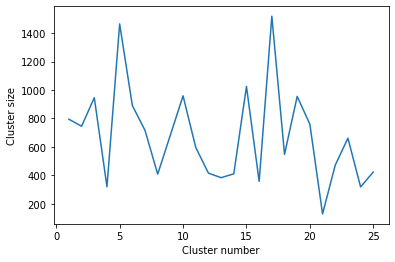

In [8]:
clust_num=[]
clust_len=[]

for i, cluster in enumerate(clustered_sentences):
    clust_num.append(i+1)
    clust_len.append(len(cluster))

plt.plot(clust_num,clust_len)
plt.xlabel('Cluster number') 
plt.ylabel('Cluster size') 
plt.show()

In [43]:
import faiss

In [9]:
range_n_clusters = []
for i in range(200,1001,100):
    range_n_clusters.append(i)
silhouette_avg = []

for num_clusters in range_n_clusters:
    # initialise kmeans
    
    clustering_model = KMeans(n_clusters=num_clusters,random_state=0).fit(context_sentence_embeddings_values)
#     clustering_model = faiss.Kmeans(d=context_sentence_embeddings_values.shape[1], k=num_clusters).train(context_sentence_embeddings_values.astype(np.float32))
    cluster_assignment = clustering_model.labels_
#     cluster_assignment = clustering_model.index.search(context_sentence_embeddings_values.astype(np.float32), 1)[1]


    # silhouette score
    
    score = silhouette_score(context_sentence_embeddings_values, cluster_assignment)
    silhouette_avg.append(score)
    print("Silhoutte score for {} cluster is : {}".format(num_clusters,score))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

Silhoutte score for 200 cluster is : 0.13381646573543549


KeyboardInterrupt: 

### B. Dependency Embeddings


In [63]:
f = open("sentence2embed_cbow.pickle","rb")

dep_sentence_embeddings = pickle.load(f)
f.close()

In [64]:
dep_sentence_embeddings_values = []
all_sentences = []
for sentence in dep_sentence_embeddings:
    dep_sentence_embeddings_values.append(dep_sentence_embeddings[sentence].cpu().detach().numpy())
    all_sentences.append(sentence)
dep_sentence_embeddings_values = np.array(dep_sentence_embeddings_values)


In [65]:
dep_sentence_embeddings_values.shape

(16893, 800)

In [66]:
num_clusters = 25
clustering_model_dep = KMeans(n_clusters=num_clusters,random_state=0).fit(dep_sentence_embeddings_values)
cluster_assignment = clustering_model_dep.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(all_sentences[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(len(cluster))
    print("")

Cluster  1
372

Cluster  2
1507

Cluster  3
1815

Cluster  4
418

Cluster  5
870

Cluster  6
540

Cluster  7
889

Cluster  8
1441

Cluster  9
386

Cluster  10
625

Cluster  11
717

Cluster  12
415

Cluster  13
432

Cluster  14
555

Cluster  15
654

Cluster  16
293

Cluster  17
579

Cluster  18
1025

Cluster  19
604

Cluster  20
166

Cluster  21
454

Cluster  22
1117

Cluster  23
257

Cluster  24
175

Cluster  25
587



In [67]:
f = open('dep_cluster_25.pickle','wb')
pickle.dump(clustering_model_dep,f)
f.close()

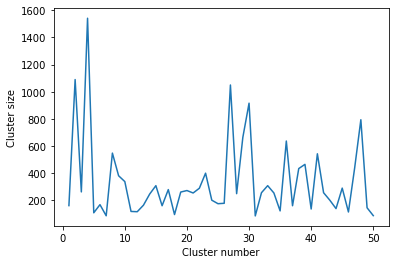

In [49]:
clust_num=[]
clust_len=[]

for i, cluster in enumerate(clustered_sentences):
    clust_num.append(i+1)
    clust_len.append(len(cluster))

plt.plot(clust_num,clust_len)
plt.xlabel('Cluster number') 
plt.ylabel('Cluster size') 
plt.show()

Silhoutte score for 200 cluster is : 0.07768619805574417
Silhoutte score for 300 cluster is : 0.07630135118961334
Silhoutte score for 400 cluster is : 0.07297328859567642
Silhoutte score for 500 cluster is : 0.07488345354795456
Silhoutte score for 600 cluster is : 0.07934559881687164
Silhoutte score for 700 cluster is : 0.08484399318695068
Silhoutte score for 800 cluster is : 0.08513528853654861
Silhoutte score for 900 cluster is : 0.0862811878323555


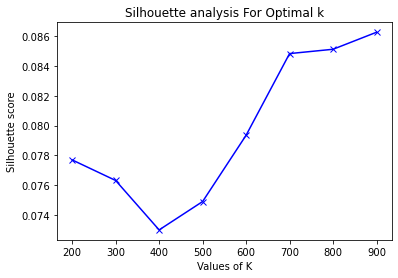

In [50]:
range_n_clusters = []
for i in range(200,1000,100):
    range_n_clusters.append(i)
silhouette_avg_dep = []

for num_clusters in range_n_clusters:
    # initialise kmeans
    
    clustering_model = KMeans(n_clusters=num_clusters,random_state=0).fit(dep_sentence_embeddings_values)
    cluster_assignment = clustering_model.labels_  

    # silhouette score
    
    score = silhouette_score(dep_sentence_embeddings_values, cluster_assignment)
    silhouette_avg_dep.append(score)
    print("Silhoutte score for {} cluster is : {}".format(num_clusters,score))
    
plt.plot(range_n_clusters,silhouette_avg_dep,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

### C. Combined Context + Dependency Embeddings

In [51]:
f = open("sentence2embed_context.pickle","rb")

context_sentence_embeddings = pickle.load(f)
f.close()

In [52]:
f = open("sentence2embed_cbow.pickle","rb")

dep_sentence_embeddings = pickle.load(f)
f.close()

In [53]:
len(context_sentence_embeddings)

16893

In [54]:
len(dep_sentence_embeddings)

16893

In [83]:
combined_sentence_embeddings = {}
for sentence in context_sentence_embeddings.keys():
    
    found = False
    for sentence2 in dep_sentence_embeddings.keys():
        if str(sentence) == str(sentence2):
            c_emb = context_sentence_embeddings[sentence] 
            d_emb = dep_sentence_embeddings[sentence2].cpu().detach().numpy()
            combined = np.hstack([c_emb,d_emb])
            combined_sentence_embeddings[sentence] = combined
            found =  True
            break
    if not found:
        print("Faulty Sentence : {}".format(sentence))



In [84]:
f = open("sentence2embed_combined.pickle","wb")

pickle.dump(combined_sentence_embeddings,f)
f.close()

## Cluster for <50 clusters 

### A. Context based Embeddings Clusters

In [20]:
f = open("sentence2embed_context.pickle","rb")

context_sentence_embeddings = pickle.load(f)
f.close()

In [21]:
context_sentence_embeddings_values = []
all_sentences = []
for sentence in context_sentence_embeddings:
    context_sentence_embeddings_values.append(context_sentence_embeddings[sentence])
    all_sentences.append(sentence)
context_sentence_embeddings_values = np.array(context_sentence_embeddings_values)


In [22]:
context_sentence_embeddings_values.shape

(16893, 768)

In [23]:
scaling=StandardScaler()

scaling.fit(context_sentence_embeddings_values)
Scaled_data=scaling.transform(context_sentence_embeddings_values)



In [24]:
principal=PCA(n_components=200)
principal.fit(Scaled_data)
context_sentence_embeddings_values = principal.transform(Scaled_data)

In [13]:
# context_sentence_embeddings_values -= np.mean(context_sentence_embeddings_values, axis = 0)
# context_sentence_embeddings_values /= np.std(context_sentence_embeddings_values, axis = 0)

In [25]:
context_sentence_embeddings_values.shape

(16893, 200)

In [26]:
num_clusters = 50
clustering_model = KMeans(n_clusters=num_clusters,random_state=0).fit(context_sentence_embeddings_values)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(all_sentences[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
[Adam McQuaid was drafted to the Columbus Blue Jackets out of Columbus, Ohio and whose general manager is Jarmo Kekalainen., Aleksander Barkov Jr was born in Tampere Finland on 2nd September 1995 and his draft team was the Florida Panthers., Akeem Ayers was born on July 10th 1989 and has played linebacker for the Tennessee Titans and the Los Angeles Rams., Akeem Dent was born in Atlanta Georgia and plays for the Houston Texans club., Akeem Ayers made his debut for Nashville based team the Tennessee Titans, later playing for the St Louis Rams., was born in Tampere, Finland (1995) and his club is the Florida Panthers., Aleksander Barkov Jr, who plays for the Florida Panthers, was born in Tampere, Finland on 2 September 1995., He plays in the position of linebacker and made his debut for the Tennessee Titans before going on to play for the St. Louis Rams., Alex Tyus played basketball for the Florida Gators at College., His debut team was the Tennessee Titans and he used to play

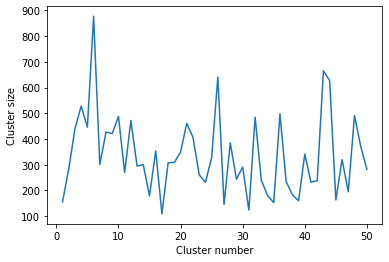

In [27]:
clust_num=[]
clust_len=[]

for i, cluster in enumerate(clustered_sentences):
    clust_num.append(i+1)
    clust_len.append(len(cluster))

plt.plot(clust_num,clust_len)
plt.xlabel('Cluster number') 
plt.ylabel('Cluster size') 
plt.show()

Silhoutte score for 5 cluster is : 0.06349503993988037
Silhoutte score for 10 cluster is : 0.07422707229852676
Silhoutte score for 15 cluster is : 0.08388115465641022
Silhoutte score for 20 cluster is : 0.08387359231710434
Silhoutte score for 25 cluster is : 0.08908309042453766
Silhoutte score for 30 cluster is : 0.0842520073056221
Silhoutte score for 35 cluster is : 0.09036874771118164
Silhoutte score for 40 cluster is : 0.09116058796644211
Silhoutte score for 45 cluster is : 0.09280166774988174
Silhoutte score for 50 cluster is : 0.09968271851539612
Silhoutte score for 55 cluster is : 0.10260255634784698
Silhoutte score for 60 cluster is : 0.09975079447031021
Silhoutte score for 65 cluster is : 0.10846826434135437
Silhoutte score for 70 cluster is : 0.10813359916210175
Silhoutte score for 75 cluster is : 0.11058501899242401
Silhoutte score for 80 cluster is : 0.11504191905260086
Silhoutte score for 85 cluster is : 0.11286508291959763
Silhoutte score for 90 cluster is : 0.115504391491

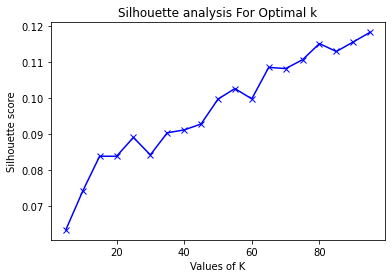

In [28]:
range_n_clusters = []
for i in range(5,100,5):
    range_n_clusters.append(i)
silhouette_avg = []

for num_clusters in range_n_clusters:
    # initialise kmeans
    
    clustering_model = KMeans(n_clusters=num_clusters,random_state=0).fit(context_sentence_embeddings_values)
#     clustering_model = faiss.Kmeans(d=context_sentence_embeddings_values.shape[1], k=num_clusters).train(context_sentence_embeddings_values.astype(np.float32))
    cluster_assignment = clustering_model.labels_
#     cluster_assignment = clustering_model.index.search(context_sentence_embeddings_values.astype(np.float32), 1)[1]
#     y_pred = clustering_model.predict(context_sentence_embeddings_values)

    # silhouette score
    
    score = silhouette_score(context_sentence_embeddings_values, cluster_assignment)
    silhouette_avg.append(score)
    print("Silhoutte score for {} cluster is : {}".format(num_clusters,score))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

### B. Dependency Based Clusters 

In [15]:
f = open("sentence2embed_cbow.pickle","rb")

dep_sentence_embeddings = pickle.load(f)
f.close()

In [16]:
dep_sentence_embeddings_values = []
all_sentences = []
for sentence in dep_sentence_embeddings:
    dep_sentence_embeddings_values.append(dep_sentence_embeddings[sentence].cpu().detach().numpy())
    all_sentences.append(sentence)
dep_sentence_embeddings_values = np.array(dep_sentence_embeddings_values)


In [17]:
num_clusters = 50
clustering_model = KMeans(n_clusters=num_clusters,random_state=0).fit(dep_sentence_embeddings_values)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(all_sentences[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
[Its Latin name is "Universitas Apulensis," its rector is "Breaz Valer Daniel," and its nickname is Uab., Ayam penyet is a dish from the region of Singapore, its country is Java, where there is a ethnic group called The Javanese., Alan Shepard's time in space is 13017 minutes, he was on the crew of Apollo 14 and his birth place was New Hampshire., The official language is Italian, the capital is Rome and the country's leader is Pietro Grasso., Bakewell tart is a dish that comes from the Derbyshire Dales region, it includes shortcrust pastry and is a variant of the Bakewell pudding., Arlington is part of Tarrant County, the county seat of which is Fort Worth., Andrews County airport is in Texas where the capital city is Austin, the local people are known as Tejano and the spoken language is English., Otkrytiye Arena is the home ground of FC Spartak Moscow, one of the clubs, Aleksandr Prudnikov played for., Ampara Hospital is in Sri Lanka, where the leader is Ranil Wickremesin

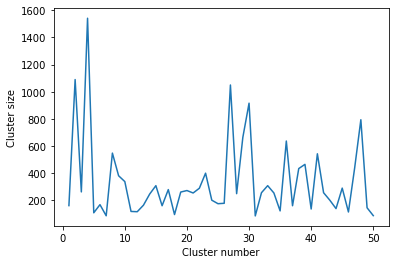

In [18]:
clust_num=[]
clust_len=[]

for i, cluster in enumerate(clustered_sentences):
    clust_num.append(i+1)
    clust_len.append(len(cluster))

plt.plot(clust_num,clust_len)
plt.xlabel('Cluster number') 
plt.ylabel('Cluster size') 
plt.show()

Silhoutte score for 5 cluster is : 0.07895689457654953
Silhoutte score for 10 cluster is : 0.09010767191648483
Silhoutte score for 15 cluster is : 0.07118930667638779
Silhoutte score for 20 cluster is : 0.06719649583101273
Silhoutte score for 25 cluster is : 0.067312091588974
Silhoutte score for 30 cluster is : 0.06726627796888351
Silhoutte score for 35 cluster is : 0.06923636794090271
Silhoutte score for 40 cluster is : 0.06936156749725342
Silhoutte score for 45 cluster is : 0.07631873339414597
Silhoutte score for 50 cluster is : 0.07363211363554001
Silhoutte score for 55 cluster is : 0.0697692409157753
Silhoutte score for 60 cluster is : 0.07812152802944183
Silhoutte score for 65 cluster is : 0.07315746694803238
Silhoutte score for 70 cluster is : 0.07467383146286011
Silhoutte score for 75 cluster is : 0.07636938989162445
Silhoutte score for 80 cluster is : 0.07152492552995682
Silhoutte score for 85 cluster is : 0.07118665426969528
Silhoutte score for 90 cluster is : 0.07019361108541

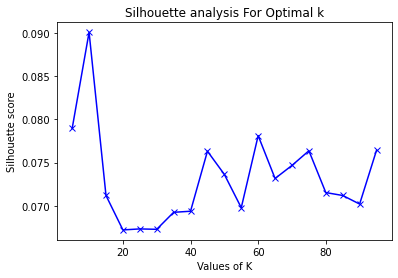

In [19]:
range_n_clusters = []
for i in range(5,100,5):
    range_n_clusters.append(i)
silhouette_avg_dep = []

for num_clusters in range_n_clusters:
    # initialise kmeans
    
    clustering_model = KMeans(n_clusters=num_clusters,random_state=0).fit(dep_sentence_embeddings_values)
    cluster_assignment = clustering_model.labels_  

    # silhouette score
    
    score = silhouette_score(dep_sentence_embeddings_values, cluster_assignment)
    silhouette_avg_dep.append(score)
    print("Silhoutte score for {} cluster is : {}".format(num_clusters,score))
    
plt.plot(range_n_clusters,silhouette_avg_dep,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

### Dependency + Combined Clusters 

In [68]:
f = open("sentence2embed_combined.pickle","rb")

combined_sentence_embeddings = pickle.load(f)
f.close()

In [69]:
comb_sentence_embeddings_values = []
all_sentences = []
for sentence in combined_sentence_embeddings:
    comb_sentence_embeddings_values.append(combined_sentence_embeddings[sentence])
    all_sentences.append(sentence)
comb_sentence_embeddings_values = np.array(comb_sentence_embeddings_values)


In [70]:
num_clusters = 25
clustering_model_comb = KMeans(n_clusters=num_clusters,random_state=0).fit(comb_sentence_embeddings_values)
cluster_assignment = clustering_model_comb.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(all_sentences[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(len(cluster))
    print("")

Cluster  1
1263

Cluster  2
1747

Cluster  3
590

Cluster  4
230

Cluster  5
688

Cluster  6
821

Cluster  7
258

Cluster  8
1365

Cluster  9
1044

Cluster  10
307

Cluster  11
588

Cluster  12
848

Cluster  13
343

Cluster  14
137

Cluster  15
294

Cluster  16
315

Cluster  17
1143

Cluster  18
559

Cluster  19
538

Cluster  20
417

Cluster  21
550

Cluster  22
547

Cluster  23
514

Cluster  24
87

Cluster  25
1700



In [71]:
f = open('combined_cluster_25.pickle','wb')
pickle.dump(clustering_model_comb,f)
f.close()

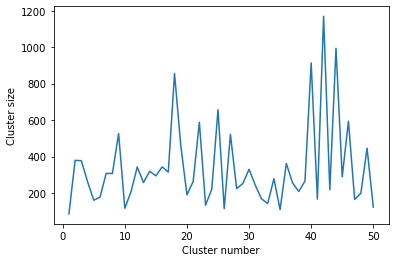

In [25]:
clust_num=[]
clust_len=[]

for i, cluster in enumerate(clustered_sentences):
    clust_num.append(i+1)
    clust_len.append(len(cluster))

plt.plot(clust_num,clust_len)
plt.xlabel('Cluster number') 
plt.ylabel('Cluster size') 
plt.show()

Silhoutte score for 5 cluster is : 0.07260913401842117
Silhoutte score for 10 cluster is : 0.06285575777292252
Silhoutte score for 15 cluster is : 0.05438770726323128
Silhoutte score for 20 cluster is : 0.0485195554792881
Silhoutte score for 25 cluster is : 0.047417379915714264
Silhoutte score for 30 cluster is : 0.050695713609457016
Silhoutte score for 35 cluster is : 0.05762498825788498
Silhoutte score for 40 cluster is : 0.05081946402788162
Silhoutte score for 45 cluster is : 0.05808693915605545
Silhoutte score for 50 cluster is : 0.05743764340877533
Silhoutte score for 55 cluster is : 0.05566384270787239
Silhoutte score for 60 cluster is : 0.05071311816573143
Silhoutte score for 65 cluster is : 0.05452292785048485
Silhoutte score for 70 cluster is : 0.05652981996536255
Silhoutte score for 75 cluster is : 0.05404362455010414
Silhoutte score for 80 cluster is : 0.052234504371881485
Silhoutte score for 85 cluster is : 0.056907594203948975
Silhoutte score for 90 cluster is : 0.05619353

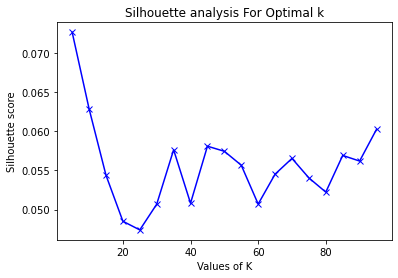

In [26]:
range_n_clusters = []
for i in range(5,100,5):
    range_n_clusters.append(i)
silhouette_avg_dep = []

for num_clusters in range_n_clusters:
    # initialise kmeans
    
    clustering_model = KMeans(n_clusters=num_clusters,random_state=0).fit(comb_sentence_embeddings_values)
    cluster_assignment = clustering_model.labels_  

    # silhouette score
    
    score = silhouette_score(comb_sentence_embeddings_values, cluster_assignment)
    silhouette_avg_dep.append(score)
    print("Silhoutte score for {} cluster is : {}".format(num_clusters,score))
    
plt.plot(range_n_clusters,silhouette_avg_dep,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

# Final Testing on the generated sentences from the T5 model

In [6]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm
import pickle
from collections import Counter
import spacy
from sklearn.metrics import silhouette_score
from spacy import displacy
import ast
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/manak18340/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/manak18340/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
file2 = open('sentences_final.txt', 'r')
da = file2.readlines()


In [8]:

for line in da:
    
    myString = re.sub(r"[\n\t\s]*", "", line)
    print(myString)

{'preds_test_both':['AbileneRegionalAirportservesthecityofAbilene,'
'Texas.',
'AdolfoSuárezMadrid–BarajasAirportcanbefoundin'
'Madrid,ParacuellosdeJarama,SanSebastiándelos'
'ReyesandAlcobendas.',
'TherunwaynameofAdolfoSuárezMadrid–BarajasAirport'
'is18L/36R.',
'TheICAOLocationIdentifierofAfonsoPena'
'InternationalAirportisSBCT.',
'AfonsoPenaInternationalAirportservesthecityof'
'Curitiba.',
'TheAlTaqaddumAirBaseservesthecityofFallujah.',
'TherunwaylengthofAlTaqaddumAirBaseis3684.0.',
'TherunwaynameofAlderneyAirportis14/32.',
'TherunwaylengthofAllamaIqbalInternationalAirport'
'is3360.12.',
'The1strunwayatAmsterdamAirportSchipholhasthe'
'number18.',
'The5thrunwayatAmsterdamAirportSchipholismade'
'fromasphalt.',
'AmsterdamAirportSchipholrunwaynameis06/24'
'Kaagbaan.',
'AndrewsCountyAirportis973metresabovesealevel.',
'AndrewsCountyAirportisownedbyAndrewsCounty,'
'Texas.',
'TherunwaylengthofAndrewsCountyAirportis896.',
'The1strunwayatAngolaInternationalAirportismade'
'fromAsphalt.',
'Antwerp

'ASeveredWaspisavailableinprintandhastheISBN'
'number0-374-26131-8.',
'JuliusSpringeristhefounderofSpringer'
'Science+BusinessMediawhichisthepublisherof'
'AbhandlungenausdemMathematischenSeminarder'
'UniversitätHamburg.',
'ThebookAlcatrazVersustheEvilLibrariansisfantasy'
'literatureandhastheISBNnumber0-439-92550-9.',
'AlcatrazVersustheEvilLibrarianshasanISBNnumber'
'of0-439-92550-9andanOCLCnumberof78771100.',
'AlcatrazVersustheEvilLibrarianswaswrittenby'
'BrandonSandersonandfollowedbythebookAlcatraz'
"VersustheScrivener'sBones.",
'TheAmericanJournalofMathematics,abbreviatedtoAm.'
'J.Math.,comesundertheacademicdisciplineofMath.',
'JohnsHopkinsUniversityistheparentcompanyofJohns'
'HopkinsUniversityPresswhichpublishestheAmerican'
'JournalofMathematics.',
'1634TheRamRebellioncomesfromtheUnitedStates'
'wherethecapitalcityisWashingtonDC.',
'AFortressofGreyIceisfromtheUnitedStateswhere'
'thecapitalisWashingtonDC.',
'AFortressofGreyIceisfromtheUnitedStateswhere'
'AfricanAmericansareoneoftheeth

'AleksandrPrudnikovwasbornonFebruary24,1989and'
'playsforFCKubanKrasnodarandFCAlania'
'Vladikavkaz.',
'AleksandrPrudnikovwasbornonFebruary24,1989and'
'playsfortheRussianationalfootballBteamandFC'
'TomTomsk.',
'AleksandreGuruliisintheAZALPFKclubandplays'
'forOlympiqueLyonnais.ThegroundofOlympique'
'LyonnaisislocatedattheParcOlympiqueLyonnais.',
'AleksandreGuruliisintheUSLesquinclubandplays'
'forOlympiqueLyonnais.ThegroundofOlympique'
'LyonnaisislocatedattheParcOlympiqueLyonnais.',
'AlessioRomagnoliplaysfortheItalynational'
'under-16footballteamandismanagedbySinisa'
'Mihajlovic.',
'AlessioRomagnoliplaysforU.C.Sampdoriaandis'
'affiliatedwithA.C.Milan.ThemanagerofA.C.Milan'
'isSinisaMihajlovic.',
'AlessioRomagnoliplaysforA.S.Romaandisamember'
'oftheItalynationalunder-16footballteam.Daniele'
'ZorattoisthecoachoftheItalianunder-16football'
'team.',
'AlessioRomagnoliwasborninItalyandplayedfor'
'U.C.SampdoriaandtheItalynationalunder-17'
'footballteam.',
'AlexPlante,borninBrandon,Manitoba,hasah

In [9]:
file1 = open('t5_sentences.txt', 'r')
Lines = file1.readlines()

In [11]:

sentences = []
new_master_dict = {}
for sentence in Lines:
    new_master_dict[sentence.replace('\n',"")] = {
        
    }
    

In [12]:
# nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()
for key in tqdm(list(new_master_dict.keys()), position = 0, desc = "Progress : "):
    
#     split_sentences = master_dict[key]['split_sentences']
    dependency_relations = []
#     for sentence in split_sentences:
    doc = nlp(key)
    dependency_relations_sentence = [doc]
    for token in doc:
        dep_dict = {}
        text = str(token.text)
        Relation = str(token.dep_)
        Head = str(token.head.text)
        Children = [str(child) for child in token.children]
#             print(text, Relation , Head, Children)
        dep_dict['text'] = text
        dep_dict['Relation'] = Relation
        dep_dict['Head'] = Head
        dep_dict['Children'] = Children
        dependency_relations_sentence.append(dep_dict)
    dependency_relations.append(dependency_relations_sentence)
    new_master_dict[key]['dependency_relations'] = dependency_relations
        
#         show_dependency_graph(doc)
        
    
        

/home/manak18340/anaconda3/envs/ie-embeddings/lib/python3.9/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
Progress : 100%|████████████████████████████████████████████████████████████████████| 1857/1857 [00:47<00:00, 39.01it/s]


In [13]:
sample_idx = 1
new_master_dict[list(new_master_dict.keys())[sample_idx]]['dependency_relations']

[[adolfo suárez madrid – barajas airport is located in madrid , paracuellos de jarama , san sebastian de los reyes and alcobendas .,
  {'text': 'adolfo',
   'Relation': 'prep',
   'Head': 'located',
   'Children': ['madrid']},
  {'text': 'suárez', 'Relation': 'compound', 'Head': 'madrid', 'Children': []},
  {'text': 'madrid',
   'Relation': 'pobj',
   'Head': 'adolfo',
   'Children': ['suárez', '–']},
  {'text': '–', 'Relation': 'punct', 'Head': 'madrid', 'Children': []},
  {'text': 'barajas',
   'Relation': 'compound',
   'Head': 'airport',
   'Children': []},
  {'text': 'airport',
   'Relation': 'nsubjpass',
   'Head': 'located',
   'Children': ['barajas']},
  {'text': 'is', 'Relation': 'auxpass', 'Head': 'located', 'Children': []},
  {'text': 'located',
   'Relation': 'ROOT',
   'Head': 'located',
   'Children': ['adolfo', 'airport', 'is', 'in', '.']},
  {'text': 'in',
   'Relation': 'prep',
   'Head': 'located',
   'Children': ['madrid']},
  {'text': 'madrid',
   'Relation': 'pobj'

In [14]:
def generate_eval_dataset(new_master_dict, context_size):
    data = []
    sentence2context_target = {}

    for sentence in new_master_dict:
        sentence2dep = new_master_dict[sentence]
        dependency_relations = sentence2dep['dependency_relations']

        for rel in dependency_relations:
            sentence = rel[0]
            for token in np.array(rel)[1:]:
                children = np.array(token['Children'])
                target = token['text']
                if len(children) >= 2*context_size:
                    context = children[:4].tolist()
                    sentence2context_target[sentence] = (context, target)
                    data.append((context, target))
                    
                    

        
    
    return data , sentence2context_target
        


In [15]:
eval_data, sentence2context_target_eval = generate_eval_dataset(new_master_dict, 2)

/tmp/ipykernel_2076323/799299844.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for token in np.array(rel)[1:]:


In [18]:
model = torch.load('cbow_model')

In [32]:
model

CBOW(
  (embeddings): Embedding(15013, 200)
  (linear1): Linear(in_features=800, out_features=256, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=256, out_features=15013, bias=True)
  (softmax): LogSoftmax(dim=-1)
)

In [33]:
inv_map_sentence2context_target_eval = {str(v): k for k, v in sentence2context_target_eval.items()}


In [34]:
indexed_data_eval = []
cleaned_sentence2context_target_eval = {}
false_count = 0
for context, target in eval_data:
    try:
        sen = inv_map_sentence2context_target_eval[str((context,target))]
        indexed_data_eval.append(([w2i[w] for w in context],w2i[target]))
        cleaned_sentence2context_target_eval[sen] = (context,target)
    except:
        false_count = false_count+1
print(false_count)
                            
                 

1647


In [35]:
len(indexed_data_eval)

857

In [38]:
sentence2embed_eval = {}
for batch, (context, target) in enumerate(get_batches(indexed_data_eval, 2)):
    context = context.to(device)
    target = target.to(device)

    con  = torch.autograd.Variable(context)
    t = torch.autograd.Variable(target).to(device)
    out,embed =  model(context)
    
    
    for c,t,o in zip(context,target, embed):
        c = [i2w[w] for w in c.tolist()]

        t = i2w[t.tolist()[0]]
        
#         print("Dependency Embeddings for the sentence -->>>>{} is ---->>>> {}".format(inv_map_sentence2context_target[str((c,t))],o))
        sentence2embed_eval[inv_map_sentence2context_target_eval[str((c,t))]] = o
    


In [39]:

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens', device = device)

In [40]:
new_sentences_eval = []
tokenized_sent_eval = []
for  sentence in sentence2embed_eval.keys():
    new_sentences_eval.append(str(sentence))
    try:
        tokenized_sent_eval.append(word_tokenize(sentence.lower()))
    except:
        pass

sentence_embeddings_eval = sbert_model.encode(new_sentences_eval)
print(len(sentence_embeddings_eval), sentence_embeddings_eval.shape)


483 (483, 768)


In [41]:
sentence2embed_context_eval = {}

for sentence,embed  in zip(sentence2embed_eval.keys(), sentence_embeddings_eval):
    sentence2embed_context_eval[sentence] = embed

In [42]:
combined_sentence_embeddings_eval = {}
for sentence in sentence2embed_context_eval.keys():
    
    found = False
    for sentence2 in sentence2embed_eval.keys():
        if str(sentence) == str(sentence2):
            c_emb = sentence2embed_context_eval[sentence] 
            d_emb = sentence2embed_eval[sentence2].cpu().detach().numpy()
            combined = np.hstack([c_emb,d_emb])
            combined_sentence_embeddings_eval[sentence] = combined
            found =  True
            break
    if not found:
        print("Faulty Sentence : {}".format(sentence))



In [43]:
len(combined_sentence_embeddings_eval.keys())

483

In [44]:
f = open('combined_cluster_25.pickle', 'rb')
combined_clustering_model = pickle.load(f)
f.close()

In [45]:
combined_eval_sentences = []
all_sentences_eval = []
for sentence in combined_sentence_embeddings_eval.keys():
    combined_eval_sentences.append(combined_sentence_embeddings_eval[sentence])
    all_sentences_eval.append(sentence)
combined_eval_sentences = np.array(combined_eval_sentences)

In [46]:
combined_eval_sentences.shape

(483, 1568)

In [47]:
y_pred = combined_clustering_model.predict(combined_eval_sentences)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [48]:
clusters = {}

for cluster_i, sentence in zip(y_pred, all_sentences_eval):
    
    c_name = "Cluster_" + str(cluster_i)
    if c_name not in clusters:
        clusters[c_name] = []
    clusters[c_name].append(sentence)

In [49]:
l = []
for key in sorted(clusters.keys()):
    
    l.append(len(clusters[key]))

print(sorted(l))

[1, 5, 6, 7, 8, 9, 9, 11, 12, 14, 14, 14, 16, 17, 19, 24, 28, 31, 34, 34, 38, 40, 43, 49]


In [50]:
string = ""
for cluster in clusters:
    print(cluster, len(clusters[cluster]))
    string = string + cluster + "\n\n"
    for sen in clusters[cluster]:
        print(sen)
        string = string + str(sen) + "\n"

    print()
    string = string + "\n\n"

Cluster_15 14
the editor of aip advances is a . t . charlie johnson who lives in the united states and attended stanford university .
a . c . chievo verona ' s ground is in verona , italy and they have 39371 members .
andrew rayel ( born in chisinau , moldova ) is a member of the christian burns and armin van buuren bands . he is in the genre of trance and started working in 2009 .
the arctech helsinki shipyard was the builders of the icebreaker , which is in service and has a length of 21 . 2 .
airey neave was born in knightsbridge , london on march 4th , 1974 . he fought in the battle of france and retired on march 30th , 1979 .
christian burns and jonathan mendelsohn are both associated with andrew rayel , who is in the genre of trance and started in 2009 .
the manager of fc terek grozny is rashid rakhimov . the club ' s ground is in the city of grazny and their youth club is fc spartak moscow .
anders osborne is a member of the band the voice of the wetlands all - stars . he is als

In [51]:
with open('eval_results_clusters.txt', 'w') as f:
    f.write(string)

In [52]:
standford_df = pd.read_csv('stanford-new.txt', sep='\t', header=None)


In [53]:
source_triples = open('test_both.source', 'r').readlines()

In [54]:
triples = []

for t in source_triples:
    t = t.replace("<H>" , "\t")
    t = t.replace("<R>" , "\t")
    t = t.replace("<T>" , "\t")
    t = t.replace('\n', '')
    st = t.split('\t')
    
    n = len(st)
    curr_triples = []
    for i in range(1,n,3):
        curr_triples.append(tuple(st[i:i+3]))
    triples.append(curr_triples)


In [55]:
len(triples)

1862

In [56]:
file1 = open('t5_sentences.txt', 'r')
Lines = file1.readlines()

sentences = []
for sentence in Lines:
    sentences.append(sentence.replace('\n',"")) 
print(len(sentences))

1862


In [57]:
# Sentence Original
sentence2triple_original = {}
for s,t in zip(sentences,triples):
    
    if s in sentence2triple_original:
        sentence2triple_original[s].extend(t)
    else:
        sentence2triple_original[s] = t

In [58]:
standford_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,clustered_sentences.txt,0,polydor records,is located in,london,0,2,2,5,5,6,1.0,polydor records is located in london .,NN NNS VBZ VBN IN NNP .,polydor record,be locate in,london
1,clustered_sentences.txt,0,polydor records,is,located,0,2,2,3,3,4,1.0,polydor records is located in london .,NN NNS VBZ VBN IN NNP .,polydor record,be,locate
2,clustered_sentences.txt,1,city,is,rock,12,13,13,14,15,16,1.0,"austin is part of williamson county , texas , ...","NN VBZ NN IN NN NN , NNS , WRB DT JJS NN VBZ J...",city,be,rock
3,clustered_sentences.txt,1,city,is,round rock,12,13,13,14,14,16,1.0,"austin is part of williamson county , texas , ...","NN VBZ NN IN NN NN , NNS , WRB DT JJS NN VBZ J...",city,be,round rock
4,clustered_sentences.txt,1,austin,is part of,williamson county,0,1,1,4,4,6,1.0,"austin is part of williamson county , texas , ...","NN VBZ NN IN NN NN , NNS , WRB DT JJS NN VBZ J...",austin,be part of,williamson county


In [59]:
standford_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4041 entries, 0 to 4040
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4041 non-null   object 
 1   1       4041 non-null   int64  
 2   2       4041 non-null   object 
 3   3       4041 non-null   object 
 4   4       4041 non-null   object 
 5   5       4041 non-null   int64  
 6   6       4041 non-null   int64  
 7   7       4041 non-null   int64  
 8   8       4041 non-null   int64  
 9   9       4041 non-null   int64  
 10  10      4041 non-null   int64  
 11  11      4041 non-null   float64
 12  12      4041 non-null   object 
 13  13      4041 non-null   object 
 14  14      4041 non-null   object 
 15  15      4041 non-null   object 
 16  16      4041 non-null   object 
dtypes: float64(1), int64(7), object(9)
memory usage: 536.8+ KB


In [60]:
indexes = np.array(standford_df.iloc[:,1])
head = np.array(standford_df.iloc[:,14])
relation = np.array(standford_df.iloc[:,15])
tail = np.array(standford_df.iloc[:,16])
sentence = np.array(standford_df.iloc[:,12])


In [61]:
# Standford 
standford_tuples = {}
for i,s,h,r,t  in zip(indexes, sentence, head, relation, tail):
    
    if int(i) not in standford_tuples:
        standford_tuples[int(i)] = {
            'sentence' : s,
            'tuples' : []
        }
    standford_tuples[int(i)]['tuples'].append(tuple((h,r,t)))

In [62]:
len(standford_tuples.keys())


776

In [63]:
inv_cluster_sentence_map = {}
for c in clusters:
    
    sentences = clusters[c]
    for s in sentences:
        inv_cluster_sentence_map[str(s)] = c

In [64]:
cluster_len_map = {}
string2 = ""
for key in clusters :
    cluster_len_map[key] = len(clusters[key])
    for s in clusters[key]:
        string2 +=str(s) + "\n"
        

In [65]:
cluster_len_map

{'Cluster_15': 14,
 'Cluster_5': 34,
 'Cluster_13': 6,
 'Cluster_3': 11,
 'Cluster_12': 14,
 'Cluster_20': 31,
 'Cluster_21': 28,
 'Cluster_7': 17,
 'Cluster_19': 8,
 'Cluster_16': 7,
 'Cluster_10': 9,
 'Cluster_1': 49,
 'Cluster_17': 14,
 'Cluster_0': 38,
 'Cluster_22': 24,
 'Cluster_8': 34,
 'Cluster_11': 16,
 'Cluster_24': 43,
 'Cluster_9': 19,
 'Cluster_4': 40,
 'Cluster_6': 9,
 'Cluster_14': 5,
 'Cluster_18': 12,
 'Cluster_2': 1}

In [66]:
with open('clustered_sentences.txt', 'w') as f:
    f.write(string2)

In [183]:
def get_triple_match(sentence2triple_original,sentence2triple_generated):
    main_dictionary = {}
    count = 0
    for sentence in sentence2triple_original:
        for i in sentence2triple_generated:
            sentence2 = sentence2triple_generated[i]['sentence']
            if str(sentence) == str(sentence2):
                try:
                    if inv_cluster_sentence_map[sentence2] not in main_dictionary:
                        main_dictionary[inv_cluster_sentence_map[sentence2]] = []

                    main_dictionary[inv_cluster_sentence_map[sentence2]].append({
                        'sentence' : sentence,
                        'original_triple' : sentence2triple_original[sentence],
                        'standford_triple' : sentence2triple_generated[i]['tuples'],

                    })
                except:
                    continue
                count +=1
    print(count)
    
    return main_dictionary



def get_triple_match_standford(sentence2triple_original,sentence2triple_generated):
    main_dictionary = {}
    count = 0
    for sentence in sentence2triple_original:
        sentence_split  = sentence.split('.')
#         print(sentence_split)
        for i in sentence2triple_generated:
            sentence2 = sentence2triple_generated[i]['sentence']
            for s in sentence_split:
                
                if  str(sentence2).replace('.','') == str(s):
                    try:
                        if inv_cluster_sentence_map[sentence] not in main_dictionary:
                            main_dictionary[inv_cluster_sentence_map[sentence]] = []

                        main_dictionary[inv_cluster_sentence_map[sentence]].append({
                            'sentence' : sentence,
                            'original_triple' : sentence2triple_original[sentence],
                            'standford_triple' : sentence2triple_generated[i]['tuples'],

                        })
                    except:
                        continue
                    count +=1
    print(count)
    
    return main_dictionary

In [184]:
main_dictionary_standford = get_triple_match_standford(sentence2triple_original, standford_tuples)

441


In [69]:
import math
import re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
WORD = re.compile(r"\w+")





def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def words_tokeniser(sentence):
    
    sentence = sentence.translate(string.punctuation)
    word_list = word_tokenize(sentence)
    
    
#     filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    
    return word_list

def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)



text1 = "This is a foo bar sentence ."
text2 = "This sentence is similar to a foo bar sentence ."

vector1 = text_to_vector(text1)
vector2 = text_to_vector(text2)

cosine = get_cosine(vector1, vector2)

print("Cosine:", cosine)

Cosine: 0.8616404368553293


In [70]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [71]:
def triple_match(tuple1, tuple2, thres):
    
#     s1 = text_to_vector(tuple1[0].lower())
#     p1 = text_to_vector(tuple1[1].lower())
#     o1 = text_to_vector(tuple1[2].lower())
 
#     s2 = text_to_vector(tuple2[0].lower())
#     p2 = text_to_vector(tuple2[1].lower())
#     o2 = text_to_vector(tuple2[2].lower())
    
    
    s1 = words_tokeniser(tuple1[0].lower())
    p1 = words_tokeniser(tuple1[1].lower())
    o1 = words_tokeniser(tuple1[2].lower())
 
    s2 = words_tokeniser(tuple2[0].lower())
    p2 = words_tokeniser(tuple2[1].lower())
    o2 = words_tokeniser(tuple2[2].lower())
    
    count = 0
    for w in s2:
        for w2 in s1:
            if similar(w,w2) > 0.8:
                count=count+1
                break

    count2 = 0
    for w in p2:
        for w2 in p1:
            if similar(w,w2) > 0.8:
                count2=count2+1
                break    
                
    count3 = 0
    for w in o2:
        for w2 in o1:
            if similar(w,w2) > 0.8:
                count3=count3+1
                break
    count = count/min(len(s1), len(s2))
    count2 = count2/min(len(p1), len(p2))
    count3 = count3/min(len(o1), len(o2))
    
                
    score = count + count2 + count3

    if score > thres*3:
        return True
    else:
        return False
    
    
    
    

In [155]:
def get_precision_recall(main_dictionary, thres = 0.5):
    cluster_precision_recall = {}
    
    TP = 0
    FP = 0
    FN = 0
    for cluster in main_dictionary:
        l = main_dictionary[cluster]
        tp = 0
        fp = 0
        fn = 0
        for dict_ in l:
            sentence = dict_['sentence']
            original_triples = dict_['original_triple']
            standford_triples = dict_['standford_triple']


            curr_list = []
            for tuple1 in original_triples:

                done = False
                for tuple2 in standford_triples:
                    is_match = triple_match(tuple1,tuple2,thres)

                    if is_match:
                        tp+=1
                        TP+=1
                        done =True
                        curr_list.append(tuple1)
                        break
                if not done:
                    fp+=1
                    FP+=1
                fn+= len(original_triples) - len(curr_list)
                FN+= len(original_triples) - len(curr_list)

        cluster_precision_recall[cluster] = {
            'number_of_sentences' : len(l),
            'precision' : tp/(tp + fp),
            'recall' : tp/(tp + fn)
        }
        
    cluster_precision_recall['global_stats'] = {
    'global_precision' : TP/(TP + FP),
    'global_recall' : TP/(TP + FN)}
    
        
    return cluster_precision_recall

        
        

In [156]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manak18340/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [186]:
cluster_precision_recall_standford = get_precision_recall(main_dictionary_standford)

In [187]:
cluster_precision_recall_standford

{'Cluster_1': {'number_of_sentences': 49,
  'precision': 0.21428571428571427,
  'recall': 0.06153846153846154},
 'Cluster_22': {'number_of_sentences': 27,
  'precision': 0.25225225225225223,
  'recall': 0.055445544554455446},
 'Cluster_0': {'number_of_sentences': 33,
  'precision': 0.3211009174311927,
  'recall': 0.08928571428571429},
 'Cluster_14': {'number_of_sentences': 5,
  'precision': 0.4166666666666667,
  'recall': 0.14705882352941177},
 'Cluster_5': {'number_of_sentences': 29,
  'precision': 0.3854166666666667,
  'recall': 0.10946745562130178},
 'Cluster_20': {'number_of_sentences': 30,
  'precision': 0.358695652173913,
  'recall': 0.10030395136778116},
 'Cluster_8': {'number_of_sentences': 33,
  'precision': 0.23529411764705882,
  'recall': 0.061946902654867256},
 'Cluster_7': {'number_of_sentences': 12,
  'precision': 0.4523809523809524,
  'recall': 0.12258064516129032},
 'Cluster_21': {'number_of_sentences': 27,
  'precision': 0.28431372549019607,
  'recall': 0.0765171503957

In [76]:
all_sentences_set = set()
for s in sentence2triple_original.keys():
    all_sentences_set.add(str(s))

In [77]:
reverb_df = pd.read_csv('reverb.txt', sep='\t', header=None)


In [78]:
reverb_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,/mnt/c/Users/Manak Bisht/Downloads/ReVerb/clus...,1,200 public square,is located in,cleveland,0,3,3,6,6,7,0.988600,"200 public square is located in cleveland , cu...","CD JJ NN VBZ VBN IN NN , NN NN , NNP , VBN NNS .",B-NP I-NP I-NP B-VP I-VP B-PP B-NP O B-NP I-NP...,# public square,locate in,cleveland
1,/mnt/c/Users/Manak Bisht/Downloads/ReVerb/clus...,2,11 diagonal street,is located in,south africa,0,3,3,6,6,8,0.958535,11 diagonal street is located in south africa .,CD JJ NN VBZ VBN IN JJ NN .,B-NP I-NP I-NP B-VP I-VP B-PP B-NP I-NP O,# diagonal street,locate in,south africa
2,/mnt/c/Users/Manak Bisht/Downloads/ReVerb/clus...,5,11264 claudiomaccone,has a length of,3453,0,2,2,6,6,7,0.928299,11264 claudiomaccone has a length of 3453 .,CD NN VBZ DT NN IN CD .,B-NP I-NP B-VP B-NP I-NP I-NP I-NP O,# claudiomaccone,have length of,#
3,/mnt/c/Users/Manak Bisht/Downloads/ReVerb/clus...,8,10 hygiea,has a length of,3453951582,0,2,2,6,6,7,0.928299,10 hygiea has a length of 3453951582 .,CD NN VBZ DT NN IN CD .,B-NP I-NP B-VP B-NP I-NP I-NP I-NP O,# hygiea,have length of,#
4,/mnt/c/Users/Manak Bisht/Downloads/ReVerb/clus...,10,he,plays for,the club anyang halla,2,3,3,5,5,9,0.444870,9304 and he plays for the club anyang halla .,CD CC PRP VBZ IN DT NN NN NN .,B-NP O B-NP B-VP B-PP B-NP I-NP I-NP I-NP O,he,play for,the club anyang halla


In [79]:
indexes = np.array(reverb_df.iloc[:,1])
head = np.array(reverb_df.iloc[:,15])
relation = np.array(reverb_df.iloc[:,16])
tail = np.array(reverb_df.iloc[:,17])
sentence = np.array(reverb_df.iloc[:,12])


In [80]:
len(indexes)

52

In [81]:
# Reverb 
reverb_tuples = {}
for i,s,h,r,t  in zip(indexes, sentence, head, relation, tail):
    
    if int(i) not in reverb_tuples:
        reverb_tuples[int(i)] = {
            'sentence' : s,
            'tuples' : []
        }
    reverb_tuples[int(i)]['tuples'].append(tuple((h,r,t)))

In [159]:
main_dictionary_reverb = get_triple_match(sentence2triple_original, reverb_tuples)

6


In [171]:
cluster_precision_recall_reverb = get_precision_recall(main_dictionary_reverb)

In [172]:
cluster_precision_recall_reverb

{'Cluster_20': {'number_of_sentences': 1, 'precision': 1.0, 'recall': 1.0},
 'Cluster_5': {'number_of_sentences': 1, 'precision': 0.0, 'recall': 0.0},
 'Cluster_24': {'number_of_sentences': 1, 'precision': 0.5, 'recall': 0.25},
 'Cluster_4': {'number_of_sentences': 1,
  'precision': 0.5,
  'recall': 0.3333333333333333},
 'Cluster_3': {'number_of_sentences': 1, 'precision': 0.0, 'recall': 0.0},
 'Cluster_7': {'number_of_sentences': 1, 'precision': 0.0, 'recall': 0.0},
 'global_stats': {'global_precision': 0.3,
  'global_recall': 0.15789473684210525}}

In [85]:

f = open('ollie.txt', 'r')
Lines = f.readlines()
f.close()

In [162]:
count2 = 0
i = 0
ollie_tuples = {}
while(i < len(Lines)):
    sentence = Lines[i]
    if sentence.replace('\n','') in all_sentences_set:
        count2+=1
        i+=1
        curr_dict = {
            'sentence' : sentence.replace('\n',''),
            'tuples' : []
        }
        possible_tuple = Lines[i].replace('\n','')
        while(i < len(Lines) and possible_tuple not in all_sentences_set):
            
            curr_dict['tuples'].append(possible_tuple)
            i+=1
            
            if i == len(Lines):
                break
            possible_tuple = Lines[i].replace('\n','')
    
    
    ollie_tuples[i] = curr_dict

for i in ollie_tuples:
    
    sentence = ollie_tuples[i]['sentence']
    tuples = ollie_tuples[i]['tuples']
    
    for j in range(len(tuples)):
        if tuples[j].replace('\n','') == 'No extractions found.':

            ollie_tuples[i]['tuples'] = []
            break
    
    new_tuples = []
    tuples = ollie_tuples[i]['tuples']
    for j in range(len(tuples)):
        arr = tuples[j].split(':')
#         conf = float(arr[0])
        if len(arr) >=2 :
            st = arr[1].replace('(','')
            st = st.replace(')','')

            t = tuple(st.split(';'))
            new_tuples.append(t)
        
    ollie_tuples[i]['tuples'] = new_tuples
    
print(count2)
        
                 

483


In [163]:
main_dictionary_ollie = get_triple_match(sentence2triple_original, ollie_tuples)

483


In [164]:
cluster_precision_recall_ollie = get_precision_recall(main_dictionary_ollie)

In [165]:
cluster_precision_recall_ollie

{'Cluster_1': {'number_of_sentences': 49,
  'precision': 0.3067484662576687,
  'recall': 0.09276437847866419},
 'Cluster_22': {'number_of_sentences': 24,
  'precision': 0.3516483516483517,
  'recall': 0.0855614973262032},
 'Cluster_0': {'number_of_sentences': 38,
  'precision': 0.2857142857142857,
  'recall': 0.08585858585858586},
 'Cluster_14': {'number_of_sentences': 5,
  'precision': 0.3333333333333333,
  'recall': 0.11764705882352941},
 'Cluster_5': {'number_of_sentences': 34,
  'precision': 0.30833333333333335,
  'recall': 0.08185840707964602},
 'Cluster_20': {'number_of_sentences': 31,
  'precision': 0.5376344086021505,
  'recall': 0.16339869281045752},
 'Cluster_8': {'number_of_sentences': 34,
  'precision': 0.28688524590163933,
  'recall': 0.07709251101321586},
 'Cluster_7': {'number_of_sentences': 17,
  'precision': 0.24528301886792453,
  'recall': 0.07103825136612021},
 'Cluster_21': {'number_of_sentences': 28,
  'precision': 0.3904761904761905,
  'recall': 0.1096256684491978